# FIFA Prediction
**Objective**: Dev ML model to predict First, Second and Third Place for 2018 FIFA worldcup<br>
**Features**: Kaggle historical data for past matches including friendly games, Eloranking by country<br>
**Purpose**: Submissions for DBS internal competition (Due 25/06/2018)

## 1) Data prep
Process the history kaggle data from results.csv (1930 onwards due to limitation of elorating data)<br>
Possible integration with elorating (Used custom javascript to crawl data from https://www.eloratings.net/)

In [23]:
# import libraries for data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# example making new class predictions for a classification problem
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical

# using sklearn to have 1 liner cross validation
from sklearn.model_selection import train_test_split

In [2]:
# Read .csv files from kaggle
results = pd.read_csv('datasets/results.csv')

In [3]:
# observe results
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


##### Through the exploration of data we need to find the absolute difference in score and the winning team<br>Append the corresponding results to the newly created columns [wining_team]<br>And finally, keep data of teams that make it to the group stage while dropping the rest

In [4]:
# Adding new column for winner of each match
winner = []
for i in range(len(results['home_team'])):
    if results['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Tie')
results['winning_team'] = winner

# Adding new column for goal difference in matches
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

# view new sample header
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


In [5]:
# scope current worldcup team qualifing teams
wc_teams = ['Australia', ' Iran', 'Japan', 'Korea Republic', 
            'Saudi Arabia', 'Egypt', 'Morocco', 'Nigeria', 
            'Senegal', 'Tunisia', 'Costa Rica', 'Mexico', 
            'Panama', 'Argentina', 'Brazil', 'Colombia', 
            'Peru', 'Uruguay', 'Belgium', 'Croatia', 
            'Denmark', 'England', 'France', 'Germany', 
            'Iceland', 'Poland', 'Portugal', 'Russia', 
            'Serbia', 'Spain', 'Sweden', 'Switzerland']

# Filter the 'results' dataframe to show only teams in this years' world cup, from 1930 onwards
# we only care about teams that qualify
df_teams_home = results[results['home_team'].isin(wc_teams)]
df_teams_away = results[results['away_team'].isin(wc_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,Scotland,2
10,1879-01-18,England,Wales,2,1,Friendly,London,England,England,1
11,1879-04-05,England,Scotland,5,4,Friendly,London,England,England,1
16,1881-02-26,England,Wales,0,1,Friendly,Blackburn,England,Wales,1
17,1881-03-12,England,Scotland,1,6,Friendly,London,England,Scotland,5
24,1883-02-03,England,Wales,5,0,Friendly,London,England,England,5
25,1883-02-24,England,Northern Ireland,7,0,Friendly,Liverpool,England,England,7
26,1883-03-10,England,Scotland,2,3,Friendly,Sheffield,England,Scotland,1


##### As mentioned earlier, slicing our data from 1930 onwards, due to limitation of elo ranking dataset

In [6]:
# Loop for creating a new column 'year'
year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year

# Slicing the dataset to see how many matches took place from 1930 onwards (the year of the first ever World Cup)
df_teams30 = df_teams[df_teams.match_year >= 1930]
df_teams30.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year
1230,1930-01-01,Spain,Czechoslovakia,1,0,Friendly,Barcelona,Spain,Spain,1,1930
1231,1930-01-12,Portugal,Czechoslovakia,1,0,Friendly,Lisbon,Portugal,Portugal,1,1930
1237,1930-02-23,Portugal,France,2,0,Friendly,Porto,Portugal,Portugal,2,1930
1238,1930-03-02,Germany,Italy,0,2,Friendly,Frankfurt am Main,Germany,Italy,2,1930
1240,1930-03-23,France,Switzerland,3,3,Friendly,Colombes,France,Tie,0,1930


##### Dropping unused column

In [7]:
df_teams30 = df_teams30.drop(['date', 'home_score', 'away_score', 'tournament', 'city', 'country', 'goal_difference', 'match_year'], axis=1)
df_teams30.head(5)

,home_team,away_team,winning_team
1230,Spain,Czechoslovakia,Spain
1231,Portugal,Czechoslovakia,Portugal
1237,Portugal,France,Portugal
1238,Germany,Italy,Italy
1240,France,Switzerland,Tie


Based on match year assign the relevant elo score

In [8]:
# Read .csv files from elo rating
elorating = pd.read_csv('datasets/EloRating.csv')
elorating.head(5)

,Local,Global,Team,Rating,AvgRating,AvgRank,Wins,Losses,Draws,For,Against,Year
0,1,1,Argentina,2062,3,1981,92,50,43,365,227,1930
1,2,2,Uruguay,2037,4,1950,78,54,35,299,217,1930
2,3,9,Brazil,1880,7,1892,17,16,8,68,60,1930
3,4,15,United States,1773,17,1703,7,5,2,34,35,1930
4,5,16,Paraguay,1739,16,1742,16,28,7,64,101,1930


## 2) Building our ML Model
Before building the model, we split the data into x,y (X variable like home vs away pair and Y variable who wins)<br>
probably should convert Y into 1 hot vector to avoid bias<br>
Also swap out X variable of country name into ID via hashmap (Keras Input limitation)

In [9]:
# rename winning team string as integer
df_teams30 = df_teams30.reset_index(drop=True)
df_teams30.loc[df_teams30.winning_team == df_teams30.home_team, 'winning_team']= 0
df_teams30.loc[df_teams30.winning_team == 'Tie', 'winning_team']= 1
df_teams30.loc[df_teams30.winning_team == df_teams30.away_team, 'winning_team']= 2 
df_teams30.head()

,home_team,away_team,winning_team
0,Spain,Czechoslovakia,0
1,Portugal,Czechoslovakia,0
2,Portugal,France,0
3,Germany,Italy,2
4,France,Switzerland,1


In [10]:
# convert all teams into unique ID via dictionary
finalX = df_teams30['home_team'].append(df_teams30['away_team'])
dictionary = dict([(y,x+1) for x,y in enumerate(sorted(set(finalX)))])      
df_teams30["home_team"].replace(dictionary, inplace=True)
df_teams30["away_team"].replace(dictionary, inplace=True)

# Separate X and y sets
X = df_teams30.drop(['winning_team'], axis=1)
y = df_teams30["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

# 1 hotvectorisation of our Y column to avoid bias (Also for model to predict category)
y_test_1hot = to_categorical(y_test)
y_train_1hot = to_categorical(y_train)

##### basic logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.540
Test set accuracy:  0.338


##### Noticed we only have 50+ % accuracy not very good for a ML model which should at least hit 70. We will be including elo ranking dataset as briefly mentioned above to improve our model accuracy 

##### AlternatIve model in keras
Current stack consist input layer with 2 dimension (will increase it to 3 to cater for elorating)<br>
Next 2*10 fully connected dense layers with built in activation relu<br>
Finally linear output layer (will consider swapping to softmax to squash output prediction as probability between representing win, draw or tie)

In [28]:
print("asd")
# define and fit the final model
model = Sequential()
model.add(Dense(20, input_dim=2, activation='relu'))
#model.add(LSTM(5, input_dim=2, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(3, init ='uniform', activation='softmax'))
# backprob
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# toggle verbose to print text
model.fit(X_train, y_train_1hot, validation_data=(X_test,y_test_1hot), epochs=50, verbose=1)
#model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=1000, verbose=0)

asd
Train on 13046 samples, validate on 6426 samples
Epoch 1/50
13046/13046 [==============================] - 2s 139us/step - loss: 1.3404 - categorical_accuracy: 0.4837 - val_loss: 1.2623 - val_categorical_accuracy: 0.3347
Epoch 2/50
13046/13046 [==============================] - 1s 90us/step - loss: 1.0776 - categorical_accuracy: 0.5040 - val_loss: 1.2114 - val_categorical_accuracy: 0.3382
Epoch 3/50
13046/13046 [==============================] - 1s 84us/step - loss: 1.0741 - categorical_accuracy: 0.5057 - val_loss: 1.2551 - val_categorical_accuracy: 0.3382
Epoch 4/50
13046/13046 [==============================] - 1s 82us/step - loss: 1.0657 - categorical_accuracy: 0.5055 - val_loss: 1.2404 - val_categorical_accuracy: 0.3382
Epoch 5/50
13046/13046 [==============================] - 1s 87us/step - loss: 1.0377 - categorical_accuracy: 0.5247 - val_loss: 1.3104 - val_categorical_accuracy: 0.3380
Epoch 6/50
13046/13046 [==============================] - 1s 88us/step - loss: 1.0404 - cat

13046/13046 [==============================] - 1s 90us/step - loss: 1.0090 - categorical_accuracy: 0.5397 - val_loss: 1.1802 - val_categorical_accuracy: 0.3382
Epoch 49/50
13046/13046 [==============================] - 2s 121us/step - loss: 1.0089 - categorical_accuracy: 0.5397 - val_loss: 1.1881 - val_categorical_accuracy: 0.3382
Epoch 50/50
13046/13046 [==============================] - 1s 98us/step - loss: 1.0091 - categorical_accuracy: 0.5397 - val_loss: 1.1760 - val_categorical_accuracy: 0.3382


##### Noticed we only have 50+ % accuracy not very good for a ML model which should at least hit 70. We will be including elo ranking dataset as briefly mentioned above to improve our model accuracy 

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/<br>
https://medium.com/@siavash_37715/how-to-predict-bitcoin-and-ethereum-price-with-rnn-lstm-in-keras-a6d8ee8a5109<br>
https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f<br>
https://github.com/charliechurches/Russia_World_Cup_Prediction/blob/master/Russia_World_Cup_predict.ipynb

categorical_accuracy: 53.97%
0


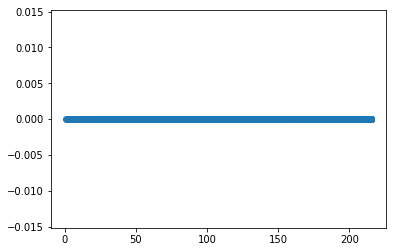

In [32]:
scores = model.evaluate(X_train, y_train_1hot, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
#print(X_test)
#print(y_test)
# sampling our model prediction
test_sample=np.array([183,66]).reshape(1,2)
# predict output index 
output=model.predict_classes(test_sample)
print(output[0])

# result verification
y_pred = model.predict_classes(X_test)
#plt.scatter(X_test['home_team'], y_test)
plt.scatter(X_test['home_team'], y_pred)
plt.show()

# too hard to see
#print(y_pred)
#print(y_test)


## 3) Creating prediction sets from current 2018 data
before final prediction we will have to clean up the dataset and merge accordingly

In [ ]:
# Loading new datasets
ranking = pd.read_csv('datasets/fifa_rankings.csv') # Obtained from https://us.soccerway.com/teams/rankings/fifa/?ICID=TN_03_05_01
fixtures = pd.read_csv('datasets/fixtures.csv') # Obtained from https://fixturedownload.com/results/fifa-world-cup-2018

# List for storing the group stage games
pred_set = []

##### include fix ranking within our 2018 group stage fixture

In [ ]:
# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
# the slice can be read as get till row 48 for all columns
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

##### predicting which team proceeds to next stage

In [ ]:

# Loop to add teams to new prediction dataset based on the ranking position of each team# Loop  
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

## 4)  Deploy Model
Using our previously trained model

In [ ]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

In [ ]:
predictions = logreg.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
    if predictions[i] == 2:
        print("Winner: " + backup_pred_set.iloc[i, 1])
    elif predictions[i] == 1:
        print("Tie")
    elif predictions[i] == 0:
        print("Winner: " + backup_pred_set.iloc[i, 0])
    print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
    print('Probability of Tie: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print("")

##### hard codethe group stage tuple all the way to the finals, this sort of flexibility instead of code driven function allows us to modify who proceed to quater finals so on and so forth based on actual results (Ideally, our model should predict the outcode for every match correctly but hey nothing is perfect right?)

In [ ]:
# List of tuples before we arrange the teams in home and away
group_16 = [('Uruguay', 'Spain'),
            ('France', 'Croatia'),
            ('Brazil', 'Mexico'),
            ('England', 'Colombia'),
            ('Portugal', 'Russia'),
            ('Argentina', 'Peru'),
            ('Germany', 'Switzerland'),
            ('Poland', 'Belgium')]

##### Function to clean tuple dataset from fixture and order by ranking (A not so nice approach to give higher ranking teams as homedue to higher win rate)

In [ ]:
def clean_and_predict(matches, ranking, final, logreg):

    # Initialization of auxiliary list for data cleaning
    positions = []

    # Loop to retrieve each team's position according to FIFA ranking
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0],'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1],'Position'].iloc[0])
    
    # Creating the DataFrame for prediction
    pred_set = []

    # Initializing iterators for while loop
    i = 0
    j = 0

    # 'i' will be the iterator for the 'positions' list, and 'j' for the list of matches (list of tuples)
    while i < len(positions):
        dict1 = {}

        # If position of first team is better, he will be the 'home' team, and vice-versa
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        # Append updated dictionary to the list, that will later be converted into a DataFrame
        pred_set.append(dict1)
        i += 2
        j += 1

    # Convert list into DataFrame
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    # Get dummy variables and drop winning_team column
    pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

    # Add missing columns compared to the model's training dataset
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    # Remove winning team column
    pred_set = pred_set.drop(['winning_team'], axis=1)

    # Predict!
    predictions = logreg.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
        if predictions[i] == 2:
            print("Winner: " + backup_pred_set.iloc[i, 1])
        elif predictions[i] == 1:
            print("Tie")
        elif predictions[i] == 0:
            print("Winner: " + backup_pred_set.iloc[i, 0])
        print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ' , '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
        print('Probability of Tie: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1])) 
        print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
        print("")

In [ ]:
# actual run
clean_and_predict(group_16, ranking, final, logreg)

##### based on previous result proceed

In [ ]:
# List of matches
quarters = [('Spain', 'France'),
            ('Portugal', 'Argentina'),
            ('Brazil', 'England'),
            ('Germany', 'Belgium')]

In [ ]:
clean_and_predict(quarters, ranking, final, logreg)

In [ ]:
# List of matches
semi = [('France', 'Brazil'),
        ('Argentina', 'Germany')]

In [ ]:
clean_and_predict(semi, ranking, final, logreg)

In [ ]:
# The final game# The big 
finals = [('Brazil', 'Germany')]

In [ ]:
clean_and_predict(finals, ranking, final, logreg)

## 5) Project Review 

Better handling of draw to proceed in matches after group stage<br>
Also ranking should be used for training and not just sorting teams between home and away<br>
Finally, betting historic data would have been helpful<br><br>

Limitation of this model would be the inability to predict score but instead predicting win or lose<br>
A separate linear regression algorithm would be use to predict the score instead